In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import warnings
from tqdm import tqdm
from yellowbrick.classifier import ROCAUC

from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score, ConfusionMatrixDisplay


GO_WORDS = [
    'sxsw', 'mention', 'apple', 'rt', 'google', 'link', 'sxswi', 'get', 'iphone',
    'ipad', 'android', 'austin', 'downtown', 'win', 'new', 'app', 'apps', 
    'line', 'mobile', 'like', 'ipads', 'store', 'people', 'one', 'dont', ]
sw = stopwords.words('english')

sw_join = [sw.append(word) for word in GO_WORDS]

TEST_SIZE = .25
RANDOM_STATE = 42
df = pd.read_csv(
    'data/tweet_tweet.csv', 
    names=['body', 'product', 'target'],
    header=0
)
cant_filter = df['target'] != "I can't tell"
#dropping product and can't tell
df = df[cant_filter]
df.drop(columns='product', inplace=True)
#dropping null
df.dropna(inplace=True)


train, test = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [2]:
class ExperimentalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,
        toker=RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)"),
        lemming=WordNetLemmatizer(),
        vectorvictor=TfidfVectorizer(),
        sw=sw_join
    ):
        '''
        A custom transformer that occasionally works in Pipeline:
            0. makes an X_copy for safety reasons
            1. makes str and lowercase
            3. tokenizes with default RegexTokenizer
            4. tags tokens with POS and converts POS to wordnet
            6. Lemmatizes with default WordNetLemmatizer
            7. creates corpus via ' '.join(X_copy)
            8. vectorizes via default TfidfVectorizer
            R. sparse matrix object
        '''
        # print('init() called.')
        self._fitted = False
        self.toker = toker
        self.lemming = lemming
        self.sw = sw
        self.vectorvictor = vectorvictor
        
        
    def _clean_me(self, words, toker, lemming):
        '''
        this is the cleaning function
        it represents steps 0 - 7
        '''
        # print('_clean_me() called.')
        words_copy = words.copy()
        words_copy = words.astype('string')
        words_copy = words_copy.apply(lambda x: x.lower())
        words_copy = words_copy.apply(lambda x: toker.tokenize(x))
        words_copy = words_copy.apply(lambda row: \
        [word for word in row if word not in self.sw])

        words_copy = words_copy.apply((lambda x: pos_tag(x)))
        words_copy = words_copy.apply(lambda row: \
        [(word[0], self.nltk_to_wordnet(word[1])) for word in row])

        words_copy = words_copy.apply(lambda row: \
        [lemming.lemmatize(word[0], word[1]) for word in row])
        
        corpus = words_copy.apply(lambda x: ' '.join(x))
        return corpus
         
        
    def fit(self, raw_doc, y=None):
        # print('fit() called.')
        cleaned = self._clean_me(raw_doc, self.toker, self.lemming)
        self.vectorvictor.fit(cleaned)
        self._fitted = True
        return self
        

    def transform(self, X, y=None):
        # print('transform() called.')
        if not self._fitted:
            raise KeyError('USER != competent /n ' \
                           'why you no fit?')
        X_copy = X.copy()
        X_copy = self._clean_me(X_copy, self.toker, self.lemming)
        vv = self.vectorvictor.transform(X_copy)
        return vv
    
#         if y != None:
#             y_copy = y.copy()
#             y_copy = self._clean_me(y_copy, self.toker, self.lemming)
#             return X_copy, y_copy
#         else:
#             return vv

    
    def nltk_to_wordnet(self, treebank_tag):
        '''
        Translate nltk POS to wordnet tags
        '''
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

top 3 are RBF SVM, Bagging, and Gradient Boosting.

Running GridSearchCV on those 3 to see what we can get.

{'for__C': 1.0, 'for__kernel': 'linear'}
gbc_gs.best_params_
{'for__learning_rate': 0.1,
 'for__max_depth': 9,
 'for__n_estimators': 100,
 'for__subsample': 1.0}

0.6763652641002685
0.6602053921705483
0.6434635294436744


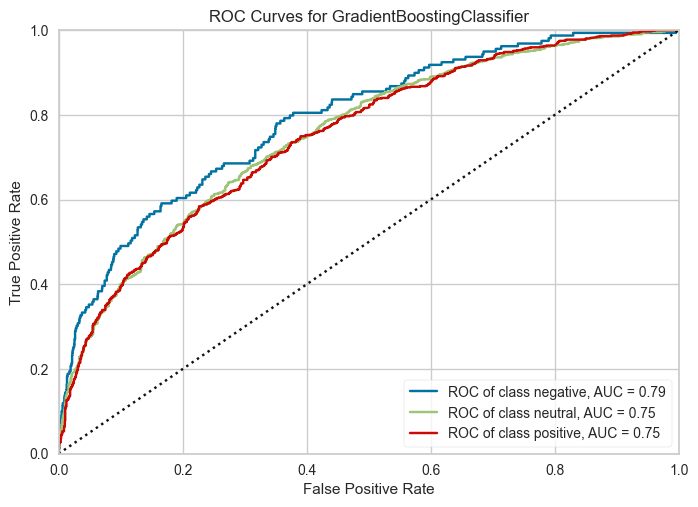

In [3]:
for_pipe = Pipeline([
    ('exp', ExperimentalTransformer()),
    ('for', GradientBoostingClassifier(
        random_state=RANDOM_STATE,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=7,
        subsample=1.0
    ))
])

for_pipe.fit(train.body, train.target)
preds = for_pipe.predict(test.body)

print(accuracy_score(test.target, preds)),
print(precision_score(test.target, preds, average='weighted')),
print(f1_score(test.target, preds, average='weighted'))

visualizer = ROCAUC(for_pipe, 
                    classes = ['negative', 'neutral', 'positive'], 
                   micro=False, macro=False)

visualizer.fit(train.body, train.target)
visualizer.score(test.body, test.target)
visualizer.show();

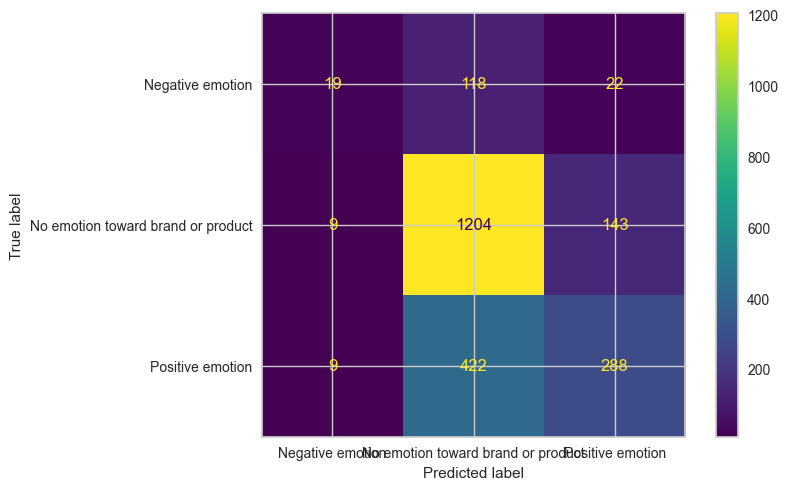

In [4]:
ConfusionMatrixDisplay.from_estimator(for_pipe, test.body, test.target);

0.6888988361683079
0.6950792922473849
0.651614418934052


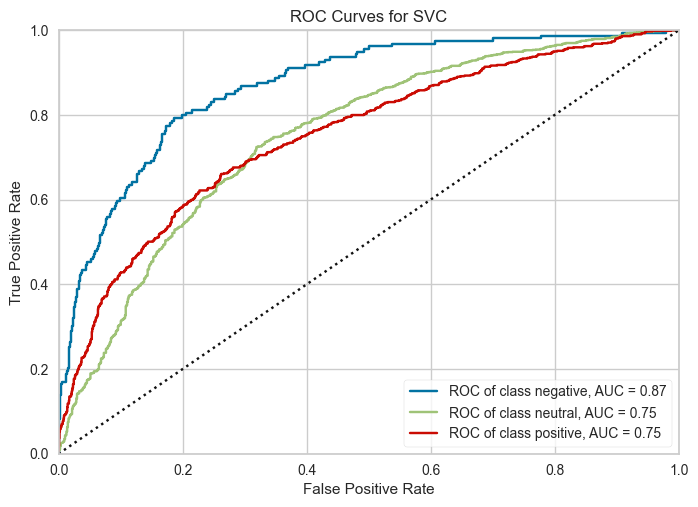

In [5]:
for_pipe = Pipeline([
    ('exp', ExperimentalTransformer()),
    ('for', SVC(gamma=2, C=1, random_state=RANDOM_STATE))
])

for_pipe.fit(train.body, train.target)
preds = for_pipe.predict(test.body)

print(accuracy_score(test.target, preds)),
print(precision_score(test.target, preds, average='weighted')),
print(f1_score(test.target, preds, average='weighted'))

visualizer = ROCAUC(for_pipe, 
                    classes = ['negative', 'neutral', 'positive'], 
                   micro=False, macro=False)

visualizer.fit(train.body, train.target)
visualizer.score(test.body, test.target)
visualizer.show();

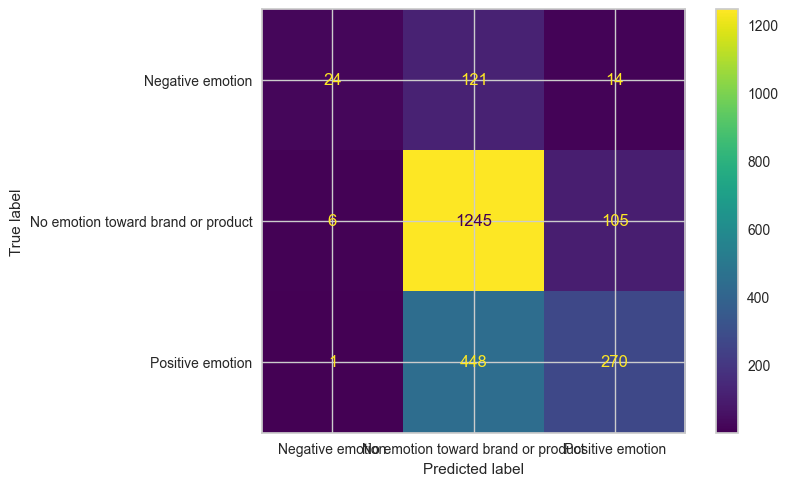

In [6]:
ConfusionMatrixDisplay.from_estimator(for_pipe, test.body, test.target);

0.6566696508504923
0.639101926099115
0.6320802236489196


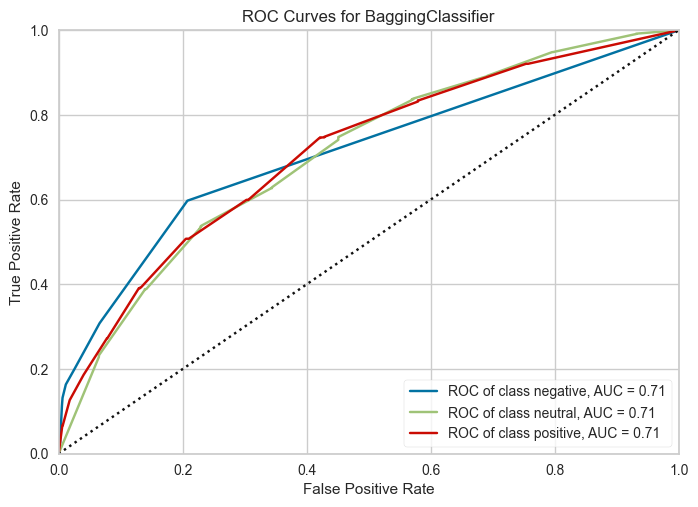

In [7]:
for_pipe = Pipeline([
    ('exp', ExperimentalTransformer()),
    ('for', BaggingClassifier())
])

for_pipe.fit(train.body, train.target)
preds = for_pipe.predict(test.body)

print(accuracy_score(test.target, preds)),
print(precision_score(test.target, preds, average='weighted')),
print(f1_score(test.target, preds, average='weighted'))

visualizer = ROCAUC(for_pipe, 
                    classes = ['negative', 'neutral', 'positive'], 
                   micro=False, macro=False)

visualizer.fit(train.body, train.target)
visualizer.score(test.body, test.target)
visualizer.show();

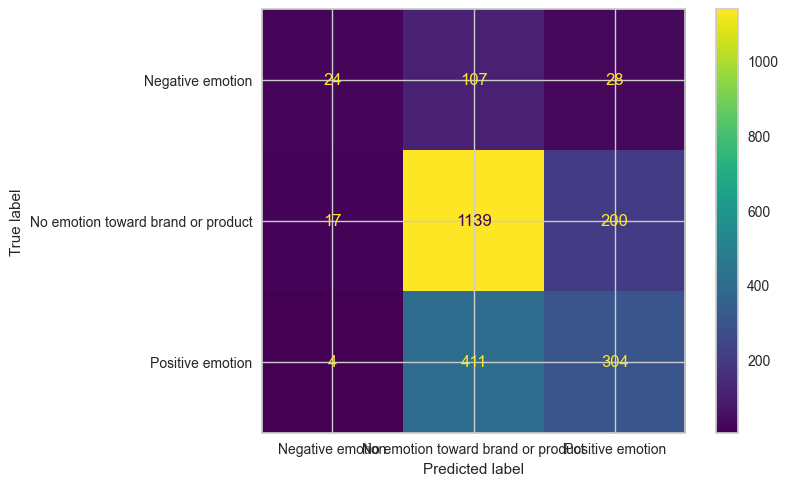

In [8]:
ConfusionMatrixDisplay.from_estimator(for_pipe, test.body, test.target);